In [2]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
plt.style.use(['science', 'notebook', 'grid'])

Building on the first fuzzy logic feedback system, I will now consider the beginning, middle and end of the repetition in addition to it as a whole. This system will take two types of inputs:
- Angular input (one for each point in the trajectory).
- Normalised time input (one for each point in the trajectory).

For each concentric and eccentric contraction, this system will say which stages (beginning, middle and end) are correct, partially correct or incorrect.

### Define Angular Error Inputs

C:\Users\Cian\Anaconda\lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


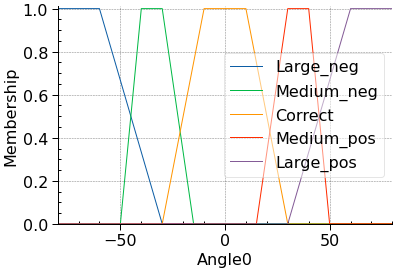

In [3]:
#define a variable that represents the number of points that will be analysed
num_inputs = 10

#Angle inputs
ang_inputs = {}
for i in range(num_inputs):
    ang_inputs[f'Angle{i}'] = ctrl.Antecedent(np.arange(-80,81,1),f'Angle{i}')

#now fuzzify each input
for j in range(num_inputs):
    ang_inputs[f'Angle{j}']['Large_neg'] = fuzz.trapmf(ang_inputs[f'Angle{j}'].universe, [-80,-80,-60,-30])
    ang_inputs[f'Angle{j}']['Medium_neg'] = fuzz.trapmf(ang_inputs[f'Angle{j}'].universe, [-50,-40,-30,-15])
    ang_inputs[f'Angle{j}']['Correct'] = fuzz.trapmf(ang_inputs[f'Angle{j}'].universe, [-30,-10,10,30])
    ang_inputs[f'Angle{j}']['Medium_pos'] = fuzz.trapmf(ang_inputs[f'Angle{j}'].universe, [15,30,40,50])
    ang_inputs[f'Angle{j}']['Large_pos'] = fuzz.trapmf(ang_inputs[f'Angle{j}'].universe, [30,60,80,80])

ang_inputs['Angle0'].view()

### Define Time Inputs

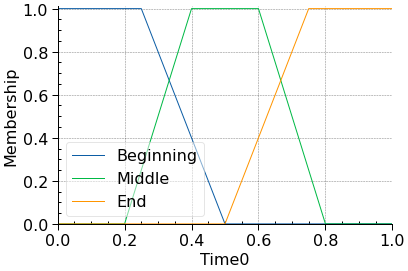

In [4]:
t_inputs = {}
for i in range(num_inputs):
    t_inputs[f'Time{i}'] = ctrl.Antecedent(np.arange(0,1.01,0.01),f'Time{i}')

#now fuzzify each input
for j in range(num_inputs):
    t_inputs[f'Time{j}']['Beginning'] = fuzz.trapmf(t_inputs[f'Time{j}'].universe, [0,0,0.25,0.5])
    t_inputs[f'Time{j}']['Middle'] = fuzz.trapmf(t_inputs[f'Time{j}'].universe, [0.2,0.4,0.6,0.8])
    t_inputs[f'Time{j}']['End'] = fuzz.trapmf(t_inputs[f'Time{j}'].universe, [0.5,0.75,1,1])
    
t_inputs['Time0'].view()

### Define Outputs

In [6]:
beg_corr = ctrl.Consequent(np.arange(-1.5, 1.51, 0.01), 'Beginning Correctness')
mid_corr = ctrl.Consequent(np.arange(-1.5, 1.51, 0.01), 'Middle Correctness')
end_corr = ctrl.Consequent(np.arange(-1.5, 1.51, 0.01), 'End Correctness')

#Now define its membership functions for beginning
beg_corr['Correct_Technique'] = fuzz.trapmf(beg_corr.universe,[0.5,0.8,1.2,1.5])
beg_corr['Medium_Technique'] = fuzz.trapmf(beg_corr.universe,[0.2,0.4,0.6,0.8])
beg_corr['Incorrect_Technique'] = fuzz.trapmf(beg_corr.universe,[-0.5,-0.2,0.2,0.5])

#Now define its membership functions for middle
mid_corr['Correct_Technique'] = fuzz.trapmf(mid_corr.universe,[0.5,0.8,1.2,1.5])
mid_corr['Medium_Technique'] = fuzz.trapmf(mid_corr.universe,[0.2,0.4,0.6,0.8])
mid_corr['Incorrect_Technique'] = fuzz.trapmf(mid_corr.universe,[-0.5,-0.2,0.2,0.5])

#Now define its membership functions for end
end_corr['Correct_Technique'] = fuzz.trapmf(end_corr.universe,[0.5,0.8,1.2,1.5])
end_corr['Medium_Technique'] = fuzz.trapmf(end_corr.universe,[0.2,0.4,0.6,0.8])
end_corr['Incorrect_Technique'] = fuzz.trapmf(end_corr.universe,[-0.5,-0.2,0.2,0.5])

### Create Logic-Based Rules

In [8]:
#initiallize an empty list that will contain all the rules.
rules = []

for i in range(num_inputs-1):
    #if all points are accurate in the beginning section, then the technique is correct.
    #First apply this to the beginning
    rules.append(ctrl.Rule(ang_inputs[f'Angle{i}']['Correct']&ang_inputs[f'Angle{i+1}']['Correct']&t_inputs[f'Time{i}']['Beginning']&t_inputs[f'Time{i+1}']['Beginning'], beg_corr['Correct_Technique']))
    
    #Repeat the above for middle time
    rules.append(ctrl.Rule(ang_inputs[f'Angle{i}']['Correct']&ang_inputs[f'Angle{i+1}']['Correct']&t_inputs[f'Time{i}']['Middle']&t_inputs[f'Time{i+1}']['Middle'], mid_corr['Correct_Technique']))
    
    #Same for the end
    rules.append(ctrl.Rule(ang_inputs[f'Angle{i}']['Correct']&ang_inputs[f'Angle{i+1}']['Correct']&t_inputs[f'Time{i}']['End']&t_inputs[f'Time{i+1}']['End'], end_corr['Correct_Technique']))
    
    
    
    #If one point is showing medium error then the technique should be of medium correctness.
    #First apply this to the beginning
    rules.append(ctrl.Rule((ang_inputs[f'Angle{i}']['Medium_pos']|ang_inputs[f'Angle{i+1}']['Medium_pos'])&(t_inputs[f'Time{i}']['Beginning']&t_inputs[f'Time{i+1}']['Beginning']), beg_corr['Medium_Technique']))
    rules.append(ctrl.Rule((ang_inputs[f'Angle{i}']['Medium_neg']|ang_inputs[f'Angle{i+1}']['Medium_neg'])&(t_inputs[f'Time{i}']['Beginning']&t_inputs[f'Time{i+1}']['Beginning']), beg_corr['Medium_Technique']))
    
    #Now apply to middle
    rules.append(ctrl.Rule((ang_inputs[f'Angle{i}']['Medium_pos']|ang_inputs[f'Angle{i+1}']['Medium_pos'])&(t_inputs[f'Time{i}']['Middle']&t_inputs[f'Time{i+1}']['Middle']), mid_corr['Medium_Technique']))
    rules.append(ctrl.Rule((ang_inputs[f'Angle{i}']['Medium_neg']|ang_inputs[f'Angle{i+1}']['Medium_neg'])&(t_inputs[f'Time{i}']['Middle']&t_inputs[f'Time{i+1}']['Middle']), mid_corr['Medium_Technique']))
    
    #Now apply to end
    rules.append(ctrl.Rule((ang_inputs[f'Angle{i}']['Medium_pos']|ang_inputs[f'Angle{i+1}']['Medium_pos'])&(t_inputs[f'Time{i}']['End']&t_inputs[f'Time{i+1}']['End']), end_corr['Medium_Technique']))
    rules.append(ctrl.Rule((ang_inputs[f'Angle{i}']['Medium_neg']|ang_inputs[f'Angle{i+1}']['Medium_neg'])&(t_inputs[f'Time{i}']['End']&t_inputs[f'Time{i+1}']['End']), end_corr['Medium_Technique']))
    
    
    #If one point is showing large error then the technique should be of low correctness.
    rules.append(ctrl.Rule((ang_inputs[f'Angle{i}']['Large_pos']|ang_inputs[f'Angle{i+1}']['Large_pos'])&(t_inputs[f'Time{i}']['Beginning']&t_inputs[f'Time{i+1}']['Beginning']), beg_corr['Incorrect_Technique']))
    rules.append(ctrl.Rule((ang_inputs[f'Angle{i}']['Large_neg']|ang_inputs[f'Angle{i+1}']['Large_neg'])&(t_inputs[f'Time{i}']['Beginning']&t_inputs[f'Time{i+1}']['Beginning']), beg_corr['Incorrect_Technique']))
    
    #Now apply to middle
    rules.append(ctrl.Rule((ang_inputs[f'Angle{i}']['Large_pos']|ang_inputs[f'Angle{i+1}']['Large_pos'])&(t_inputs[f'Time{i}']['Middle']&t_inputs[f'Time{i+1}']['Middle']), mid_corr['Incorrect_Technique']))
    rules.append(ctrl.Rule((ang_inputs[f'Angle{i}']['Large_neg']|ang_inputs[f'Angle{i+1}']['Large_neg'])&(t_inputs[f'Time{i}']['Middle']&t_inputs[f'Time{i+1}']['Middle']), mid_corr['Incorrect_Technique']))
    
    #Now apply to end
    rules.append(ctrl.Rule((ang_inputs[f'Angle{i}']['Large_pos']|ang_inputs[f'Angle{i+1}']['Large_pos'])&(t_inputs[f'Time{i}']['End']&t_inputs[f'Time{i+1}']['End']), end_corr['Incorrect_Technique']))
    rules.append(ctrl.Rule((ang_inputs[f'Angle{i}']['Large_neg']|ang_inputs[f'Angle{i+1}']['Large_neg'])&(t_inputs[f'Time{i}']['End']&t_inputs[f'Time{i+1}']['End']), end_corr['Incorrect_Technique']))

In [9]:
system = ctrl.ControlSystem(rules)

### Apply System to Real Examples
I will now code a script that uses the classification model and the regression "perfect technique" model to create inputs to the fuzzy logic system. This will complete this section

In [11]:
#import all necessary packages
import numpy as np
from keras.utils import to_categorical
from scipy.interpolate import InterpolatedUnivariateSpline
import matplotlib.pyplot as plt
plt.style.use(['science', 'notebook', 'grid'])
import sys
sys.path.append("C:\\Users\\Cian\\1 FYP Code\\Code_with_git\\Functions")
from Functions import Bicep_Curl_Classification,equal_lengths

In [121]:
#First apply the Bicep_Curl_Classification function that I have created. This extracts the relevant angles for each frame in the video in addition to classifying each frame.
# path = "C:\\Users\\Cian\\OneDrive\\Documents\\Imperial\\Year 4\\FYP\\Local Download\Technical\\Bicep Curl Analysis\\Technique Modelling\\Training Data (Videos)\\Incorrect Technique (for validation)\\2.mp4"
path = "C:\\Users\\Cian\\OneDrive\\Documents\\Imperial\\Year 4\\FYP\\Local Download\\Technical\\Bicep Curl Analysis\\Technique Modelling\\Training Data (Videos)\\Testing.mp4"
result, Angles = Bicep_Curl_Classification(path,"Final Model")

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


Now extract the frames for each concentric and eccentric contraction.

In [122]:
#Identify the locations when the class changes
change = result[1:]*result[:-1]
C = np.where(np.sum((change == np.array([0,0,0])), axis=1) == 3)[0]

#Create a list representing the class of each chunk
class_chunk = [np.argmax(result[i+1]) for i in C-1]

#Initiallize lists that will containg the data sequences for concentric/eccentric contractions
concentric = []
eccentric = []

for i in range(len(class_chunk)):
    #define the beginning of the range of frames that represent the current chunk. We define the second index later
    #Note that we need to add 9 to the value value in C, this is because a prediction isn't made on the first 9 frames.
    ind0 = C[i-1]+1+9
    
    #if i==0 then the range of frames is from the beginning (the abouve definition for ind0 doesn't apply in this case)
    if i==0:
        ind0 = 0

    #if not a bicep curl at all
    if class_chunk[i] == 0:
        pass
    
    #if concentric contraction
    elif class_chunk[i] == 1:
        #if this is the final chunk
        if i==len(class_chunk)-1:
            concentric.append(Angles[ind0:])
        else:
            ind1 = C[i]+1+9
            concentric.append(Angles[ind0:ind1])
        
    #if eccentric contraction
    elif class_chunk[i]==2:
        #if this is the final chunk
        if i==len(class_chunk)-1:
            eccentric.append(Angles[ind0:])
        else:
            ind1 = C[i]+1+9
            eccentric.append(Angles[ind0:ind1])

Interpolate the data using cubic splines, then extract evenly spaced angle values. This gives the capability of changing the number of points that we sample.

In [123]:
#First loop through concentric
#Initiallize a new list that will take the concentric contraction trajectories of custom length.
custom_con = []
for i in range(len(concentric)):
    #create the normalised time
    t = np.linspace(0,1,len(concentric[i]))
    
    #now apply the equal_lengths function, and append the result to the custom_con list.
    custom_con.append(equal_lengths(concentric[i], t, num_inputs))
    
    
    
#take the same approach for the eccentric.
custom_ecc = []
for i in range(len(eccentric)):
    #create normalised time
    t = np.linspace(0,1,len(eccentric[i]))
    
    #apply the equal_lengths function and append the result to custom_ecc
    custom_ecc.append(equal_lengths(eccentric[i],t,num_inputs))
    
#change the angle from a normalised value to be in degrees
custom_con = np.array(custom_con)*180
custom_ecc = np.array(custom_ecc)*180

Acquire corresponding values for the ideal concentric/eccentric contraction.

In [124]:
#first import the models
con_coeff = np.load('C:\\Users\\Cian\\1 FYP Code\\Code_with_git\\Prototype 2\\Technique Modelling\\Models\\Concentric.npy')
ecc_coeff = np.load('C:\\Users\\Cian\\1 FYP Code\\Code_with_git\\Prototype 2\\Technique Modelling\\Models\\Eccentric.npy')

#create a normalised time scale
time = np.linspace(0,1,num_inputs)

#in order to get coordinates from the model we use matrix multiplication with a matrix where the first row is just ones, while the second row is the normalised times.
matrix = np.stack((np.ones(num_inputs),time))

#Now calculate the correct angles for concentric and eccentric. Convert to degrees by multiplying by 180.
#Also transpose these so that the angles increment with time down the rows (matching the eccentric and concentric contraction from before)
correct_con = (con_coeff@matrix*180).T
correct_ecc = (ecc_coeff@matrix*180).T

Now I will acquire the angle error for each dimension. Note that since there is a hierarchical order to the joints (as follows):
- Torso Angle
- Upper Arm Angle
- Lower Arm Angle

So, if there is an error in the torso angle there will automatically be an error in the upper and lower arm angles, therefore, to make a fair analysis, we need to subtract the error of joints higher on the hierarchy list from each joint lower on the hierarchy list.

In [125]:
#First loop through the concentric list
error_con = []
for i in range(len(custom_con)):
    #First calculate the error in the torso angle (top of the hierarchy)
    e0 = custom_con[i][:,0] - correct_con[:,0]
    
    #Now subtract this from the angles lower on the hierarchy
    upper_arm = custom_con[i][:,1] - e0
    lower_arm = custom_con[i][:,2] - e0
    
    #Now calculate the error in the upper arm angle
    e1 = upper_arm - correct_con[:,1]
    
    #now subtract this error from the remaining angle on the hierarchy (lower arm)
    lower_arm = lower_arm - e1
    
    #Find the error in the lower arm
    e2 = lower_arm - correct_con[:,2]
    
    #concatenate all errors and then append to the error list
    error_con.append(np.stack((e0,e1,e2),axis=1))
    
    
    
#now do the same with eccentric
error_ecc = []
for i in range(len(custom_ecc)):
    #First calculate the error in the torso angle (top of the hierarchy)
    e0 = custom_ecc[i][:,0] - correct_ecc[:,0]
    
    #Now subtract this from the angles lower on the hierarchy
    upper_arm = custom_ecc[i][:,1] - e0
    lower_arm = custom_ecc[i][:,2] - e0
    
    #Now calculate the error in the upper arm angle
    e1 = upper_arm - correct_ecc[:,1]
    
    #now subtract this error from the remaining angle on the hierarchy (lower arm)
    lower_arm = lower_arm - e1
    
    #Find the error in the lower arm
    e2 = lower_arm - correct_ecc[:,2]
    
    #concatenate all errors and then append to the error list
    error_ecc.append(np.stack((e0,e1,e2),axis=1))

Now apply the fuzzy logic to each dimension in the Concentric and Eccentric.

The following cell will output two arrays representing the result, one for concentric and the other for eccentric. The form of the arrays will be as follows:
- First dimension = Each repetition seen in the video.
- Second dimension = The degrees of freedom, Torso, Upper arm, Lower Arm (in this order).
- Third dimension = The beginning, middle and end of the repetition (in this order).

In [126]:
#Initiallize simulation of the system that I have defined above.
simulation = ctrl.ControlSystemSimulation(system)

#Start with concentric
#Initiallize an empty array: first dimension represents each repetition, second dimension is the degrees of freedom (Torso, Upper and Lower arm), third dimension is the beginning, middle and end technique correctness
Concentric_Result = np.zeros((len(error_con),3,3))
for i in range(len(error_con)):
    #Loop through each dimension in hierarchical order, i.e. Torso, Upper Arm, Lower Arm
    for j in range(3):
        
        #Now loop through each point of analysis
        for k in range(num_inputs):
            
            #input each angle error as an input
            simulation.input[f'Angle{k}'] = error_con[i][k,j]
            
            #input the corresponding time as an input
            simulation.input[f'Time{k}'] = time[k]
            
        #Now run the fuzzy inference system for this dimension in this repetition
        simulation.compute()
        Concentric_Result[i,j,0] = simulation.output['Beginning Correctness']
        Concentric_Result[i,j,1] = simulation.output['Middle Correctness']
        Concentric_Result[i,j,2] = simulation.output['End Correctness']
        
        
#Repeat this with Eccentric
#Initiallize an empty array: first dimension represents each repetition, second dimension is the degrees of freedom (Torso, Upper and Lower arm), third dimension is the beginning, middle and end technique correctness
Eccentric_Result = np.zeros((len(error_ecc),3,3))
for i in range(len(error_ecc)):
    #Loop through each dimension in hierarchical order, i.e. Torso, Upper Arm, Lower Arm
    for j in range(3):
        
        #Now loop through each point of analysis
        for k in range(num_inputs):
            
            #input each angle error as an input
            simulation.input[f'Angle{k}'] = error_ecc[i][k,j]
            
            #input the corresponding time as an input
            simulation.input[f'Time{k}'] = time[k]
            
        #Now run the fuzzy inference system for this dimension in this repetition
        simulation.compute()
        Eccentric_Result[i,j,0] = simulation.output['Beginning Correctness']
        Eccentric_Result[i,j,1] = simulation.output['Middle Correctness']
        Eccentric_Result[i,j,2] = simulation.output['End Correctness']

Now write code to translate the result from above into verbal feedback.

In [139]:
##################################
##Start with concentric feedback##
##################################

concentric_feedback = []
for i in range(len(Concentric_Result)):
    current_res = Concentric_Result[i]
    
    #Initiallize a list that will contain the verbal results.
    verbal = []
    
    #loop through each degree of freedom.
    for j in range(3):
        current_dof = current_res[j]
        
        #first analyse the torso
        if j==0:
            #First check the overall correctness.
            if np.min(current_dof[:]) >=0.8:
                verbal.append('Torso correct')
            else:
                #Analyse the beginning of the repetion
                if current_dof[0]>=0.8:
                    verbal.append('Torso beginning: correct')
                elif current_dof[0]<0.8 and current_dof[0]>=0.5:
                    verbal.append('Torso beginning: needs improvement')
                elif current_dof[0]<0.5:
                    verbal.append('Torso beginning: incorrect')
                    
                #Analyse the middle of the repetition
                if current_dof[1]>=0.8:
                    verbal.append('Torso middle: correct')
                elif current_dof[1]<0.8 and current_dof[1]>=0.5:
                    verbal.append('Torso middle: needs improvement')
                elif current_dof[1]<0.5:
                    verbal.append('Torso middle: incorrect')
                    
                #Analyse the end of the repetition
                if current_dof[2]>=0.8:
                    verbal.append('Torso end: correct')
                elif current_dof[2]<0.8 and current_dof[2]>=0.5:
                    verbal.append('Torso end: needs improvement')
                elif current_dof[2]<0.5:
                    verbal.append('Torso end: incorrect')
                    
                #inform the user that results on the following degrees of freedom may be innaccurate since the incorrecness of the torso may affect it.
                verbal.append('Since the torso is not completely correct, the results for the lower and upper arm may be innaccurate. We recommend for you to correct the torso first then upload a new video featuring this correction.')
                    
                    
        #Now analyse upper arm
        if j==1:
            #First check the overall correctness.
            if np.min(current_dof[:]) >=0.8:
                verbal.append('Upper arm correct')
            else:
                #Analyse the beginning of the repetion
                if current_dof[0]>=0.8:
                    verbal.append('Upper arm beginning: correct')
                elif current_dof[0]<0.8 and current_dof[0]>=0.5:
                    verbal.append('Upper arm beginning: needs improvement')
                elif current_dof[0]<0.5:
                    verbal.append('Upper arm beginning: incorrect')
                    
                #Analyse the middle of the repetition
                if current_dof[1]>=0.8:
                    verbal.append('Upper arm middle: correct')
                elif current_dof[1]<0.8 and current_dof[1]>=0.5:
                    verbal.append('Upper arm middle: needs improvement')
                elif current_dof[1]<0.5:
                    verbal.append('Upper arm middle: incorrect')
                    
                #Analyse the end of the repetition
                if current_dof[2]>=0.8:
                    verbal.append('Upper arm end: correct')
                elif current_dof[2]<0.8 and current_dof[2]>=0.5:
                    verbal.append('Upper arm end: needs improvement')
                elif current_dof[2]<0.5:
                    verbal.append('Upper arm end: incorrect')
                    
                #inform the user that results on the following degrees of freedom may be innaccurate since the incorrecness of the upper arm may affect it.
                verbal.append('Since the upper arm is not completely correct, the results for the lower arm may be innaccurate. We recommend for you to correct the upper arm first then upload a new video featuring this correction.')
                    
                    
                    
        #Now analyse lower arm
        if j==2:
            #First check the overall correctness.
            if np.min(current_dof[:]) >=0.8:
                verbal.append('Lower arm correct')
            else:
                #Analyse the beginning of the repetion
                if current_dof[0]>=0.8:
                    verbal.append('Lower arm beginning: correct')
                elif current_dof[0]<0.8 and current_dof[0]>=0.5:
                    verbal.append('Lower arm beginning: needs improvement')
                elif current_dof[0]<0.5:
                    verbal.append('Lower arm beginning: incorrect')
                    
                #Analyse the middle of the repetition
                if current_dof[1]>=0.8:
                    verbal.append('Lower arm middle: correct')
                elif current_dof[1]<0.8 and current_dof[1]>=0.5:
                    verbal.append('Lower arm middle: needs improvement')
                elif current_dof[1]<0.5:
                    verbal.append('Lower arm middle: incorrect')
                    
                #Analyse the end of the repetition
                if current_dof[2]>=0.8:
                    verbal.append('Lower arm end: correct')
                elif current_dof[2]<0.8 and current_dof[2]>=0.5:
                    verbal.append('Lower arm end: needs improvement')
                elif current_dof[2]<0.5:
                    verbal.append('Lower arm end: incorrect')
                    
    concentric_feedback.append(verbal)
    
    
    
    
    
    
###############################
##Now with eccentric feedback##
###############################

eccentric_feedback = []
for i in range(len(Eccentric_Result)):
    current_res = Eccentric_Result[i]
    
    #Initiallize a list that will contain the verbal results.
    verbal = []
    
    #loop through each degree of freedom.
    for j in range(3):
        current_dof = current_res[j]
        
        #first analyse the torso
        if j==0:
            #First check the overall correctness.
            if np.min(current_dof[:]) >=0.8:
                verbal.append('Torso correct')
            else:                
                #Analyse the beginning of the repetion
                if current_dof[0]>=0.8:
                    verbal.append('Torso beginning: correct')
                elif current_dof[0]<0.8 and current_dof[0]>=0.5:
                    verbal.append('Torso beginning: needs improvement')
                elif current_dof[0]<0.5:
                    verbal.append('Torso beginning: incorrect')
                    
                #Analyse the middle of the repetition
                if current_dof[1]>=0.8:
                    verbal.append('Torso middle: correct')
                elif current_dof[1]<0.8 and current_dof[1]>=0.5:
                    verbal.append('Torso middle: needs improvement')
                elif current_dof[1]<0.5:
                    verbal.append('Torso middle: incorrect')
                    
                #Analyse the end of the repetition
                if current_dof[2]>=0.8:
                    verbal.append('Torso end: correct')
                elif current_dof[2]<0.8 and current_dof[2]>=0.5:
                    verbal.append('Torso end: needs improvement')
                elif current_dof[2]<0.5:
                    verbal.append('Torso end: incorrect')
                    
                #inform the user that results on the following degrees of freedom may be innaccurate since the incorrecness of the torso may affect it.
                verbal.append('Since the torso is not completely correct, the results for the lower and upper arm may be innaccurate. We recommend for you to correct the torso first then upload a new video featuring this correction.')
                    
                    
        #Now analyse upper arm
        if j==1:
            #First check the overall correctness.
            if np.min(current_dof[:]) >=0.8:
                verbal.append('Upper arm correct')
            else:
                #Analyse the beginning of the repetion
                if current_dof[0]>=0.8:
                    verbal.append('Upper arm beginning: correct')
                elif current_dof[0]<0.8 and current_dof[0]>=0.5:
                    verbal.append('Upper arm beginning: needs improvement')
                elif current_dof[0]<0.5:
                    verbal.append('Upper arm beginning: incorrect')
                    
                #Analyse the middle of the repetition
                if current_dof[1]>=0.8:
                    verbal.append('Upper arm middle: correct')
                elif current_dof[1]<0.8 and current_dof[1]>=0.5:
                    verbal.append('Upper arm middle: needs improvement')
                elif current_dof[1]<0.5:
                    verbal.append('Upper arm middle: incorrect')
                    
                #Analyse the end of the repetition
                if current_dof[2]>=0.8:
                    verbal.append('Upper arm end: correct')
                elif current_dof[2]<0.8 and current_dof[2]>=0.5:
                    verbal.append('Upper arm end: needs improvement')
                elif current_dof[2]<0.5:
                    verbal.append('Upper arm end: incorrect')
                    
                #inform the user that results on the following degrees of freedom may be innaccurate since the incorrecness of the upper arm may affect it.
                verbal.append('Since the upper arm is not completely correct, the results for the lower arm may be innaccurate. We recommend for you to correct the upper arm first then upload a new video featuring this correction.')
                    
                    
                    
        #Now analyse lower arm
        if j==2:
            #First check the overall correctness.
            if np.min(current_dof[:]) >=0.8:
                verbal.append('Lower arm correct')
            else:
                #Analyse the beginning of the repetion
                if current_dof[0]>=0.8:
                    verbal.append('Lower arm beginning: correct')
                elif current_dof[0]<0.8 and current_dof[0]>=0.5:
                    verbal.append('Lower arm beginning: needs improvement')
                elif current_dof[0]<0.5:
                    verbal.append('Lower arm beginning: incorrect')
                    
                #Analyse the middle of the repetition
                if current_dof[1]>=0.8:
                    verbal.append('Lower arm middle: correct')
                elif current_dof[1]<0.8 and current_dof[1]>=0.5:
                    verbal.append('Lower arm middle: needs improvement')
                elif current_dof[1]<0.5:
                    verbal.append('Lower arm middle: incorrect')
                    
                #Analyse the end of the repetition
                if current_dof[2]>=0.8:
                    verbal.append('Lower arm end: correct')
                elif current_dof[2]<0.8 and current_dof[2]>=0.5:
                    verbal.append('Lower arm end: needs improvement')
                elif current_dof[2]<0.5:
                    verbal.append('Lower arm end: incorrect')
                    
    eccentric_feedback.append(verbal)

In [145]:
concentric_feedback[8]

['Torso correct', 'Upper arm correct', 'Lower arm correct']

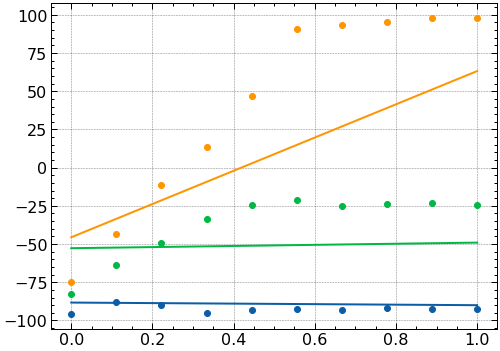

In [143]:
plt.plot(time,correct_con)
plt.scatter(time,custom_con[7,:,0])
plt.scatter(time,custom_con[7,:,1])
plt.scatter(time,custom_con[7,:,2])